In [2]:
print("hello")

hello


In [1]:
print("meowmeow")

print("hello?")

print("hehehaha")

meowmeow
hello?
hehehaha


In [3]:
print("kaiyi test")

print("weeeeeee")
print("weyuwuye")

kaiyi test
weeeeeee
weyuwuye


In [12]:
import cv2  # For image loading and processing
import os  # For handling file paths
import numpy as np  # For numerical operations
from PIL import Image, ImageEnhance  # For image loading and augmentation
import matplotlib.pyplot as plt  # For visualization
from sklearn.preprocessing import LabelEncoder  # For encoding labels
import random  # For random transformations


In [13]:
import os

dataset_folder = "/Users/siyinggg/Documents/IT1244/Train"  # Change this

# List all image files
image_files = [f for f in os.listdir(dataset_folder) if f.endswith((".png"))]

# Extract class labels
image_paths = []
labels = []

for img_file in image_files:
    class_label = img_file.split("__")[0]  # Extract the part before '__'
    labels.append(int(class_label))  # Convert class to integer
    image_paths.append(os.path.join(dataset_folder, img_file))

# Print first 5 samples
print("Sample labels:", labels[:5])
print("Sample image paths:", image_paths[:5])


Sample labels: [11, 18, 11, 8, 21]
Sample image paths: ['/Users/siyinggg/Documents/IT1244/Train/11__3528.png', '/Users/siyinggg/Documents/IT1244/Train/18__747.png', '/Users/siyinggg/Documents/IT1244/Train/11__1459.png', '/Users/siyinggg/Documents/IT1244/Train/8__1311.png', '/Users/siyinggg/Documents/IT1244/Train/21__4088.png']


In [16]:
from PIL import Image
import numpy as np

# Load and preprocess images
images = []
for img_path in image_paths:
    img = Image.open(img_path).resize((224, 224))  # Resize to 224x224
    img = np.array(img) / 255.0  # Normalize
    images.append(img)

# Convert to NumPy array
X = np.array(images)  # Features (Images)
y = np.array(labels)  # Labels

print(f"Dataset size: {X.shape}, Labels size: {y.shape}")



Dataset size: (3454, 224, 224, 3), Labels size: (3454,)


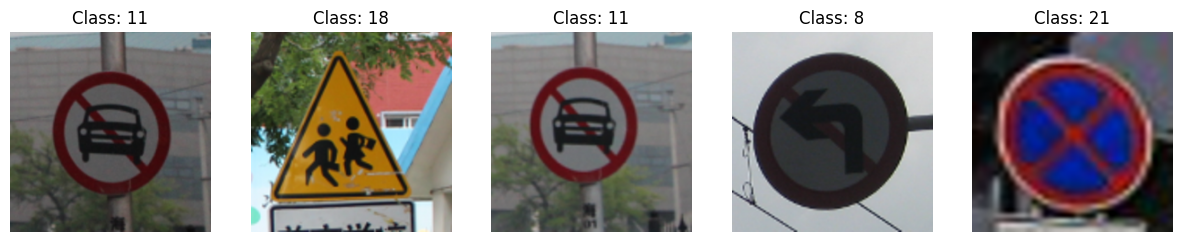

In [17]:
#Checker whether pictures matches labels
import matplotlib.pyplot as plt

# Show first 5 images with their labels
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    axes[i].imshow(X[i])  # Show image
    axes[i].set_title(f"Class: {y[i]}")  # Show corresponding label
    axes[i].axis("off")

plt.show()
